In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path

from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
geometric_graph_conf = conf

In [4]:
geometric_graph_conf

{'num_simulation_runs': 20,
 'mean_degrees': [2, 5, 10, 15, 20],
 'nodes': 500,
 'structure_names': ['random_geometric', 'barabasi_albert']}

In [48]:
import multiprocessing, itertools
from typing import Union, Optional, Tuple, List

In [14]:
conf

{'num_simulation_runs': 20,
 'mean_degrees': [2, 5, 10, 15, 20],
 'nodes': 500,
 'structure_names': ['random_geometric', 'barabasi_albert']}

In [59]:
def run_single_simulation(
    passed_inputs, 
    verbose : bool =  False 
    ):
    """
    Function to run one iteration of the simulation. Need to pass a list instead of arguments to function 
    is so that it can work with pmap.unordered
    """
    mean_degree, structure_name, modality, number_nodes = passed_inputs
    results_dict = {
    }
    if verbose: 
        print(f"simulation run for degree {mean_degree}")
    graphgen = GraphStructureGenerator(
        structure_name=structure_name, 
        num_nodes=number_nodes, 
        target_mean_degree = mean_degree
    )
    graph = graphgen.initial_adj_matrix
    graph_rand = graphgen.get_graph_structure().initial_adj_matrix

    x = ProceduralGraphGenerator(graph)
    infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
        modality=modality, verbose= False
    )

    results_dict["timesteps_saturation"] = timesteps_saturation
    results_dict["fraction_infected_list"] = fraction_infected_list
    results_dict["info_dict"] = info_dict

    return results_dict
    
def run_simulation(modality : str, mean_degree : int, structure_name : str) -> list: 
    simulation_run_list = []
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() * 2 - 1) as p:
        iterThis = itertools.repeat(
            [
                mean_degree, 
                structure_name,
                modality, 
                conf['nodes']
            ],
            conf['num_simulation_runs'],
        )
        with tqdm.tqdm(total=conf['num_simulation_runs']) as pbar:
            for _ in p.imap_unordered(run_single_simulation, iterThis):
                pbar.update()
                simulation_run_list.append(_)
    
    #Simulation run lists is a list of dicts we need to merge into a dict of list of lists
    final_dict = {k : [] for k in list(_.keys())}
    for key in final_dict.keys():
        for simulation_dict in simulation_run_list: 
            final_dict[key].append(simulation_dict[key])

    final_dict['fraction_infected_list'] = np.array(
        list(zip(*itertools.zip_longest(*final_dict['fraction_infected_list'], fillvalue=1)))
    )

    return final_dict

In [55]:
xtx = run_simulation("reversable", 10, "random_geometric")

100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


In [72]:
xtx['info_dict'][0]['modality']

'reversable'

In [68]:
def plot_results(results_dict : dict, structure_name : str ):
    for iter in results_dict['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        #try:
        #    p, cov = curve_fit(logistic, timesteps_list, iter)
        #    logistic_curve_data = logistic(timesteps_list, *p)
        #except:
        #    pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(
        f"saturation curve for {structure_name} \
        modality: {results_dict['info_dict'][0]['modality']} \
        mean degree: {round(results_dict['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

TypeError: list indices must be integers or slices, not str

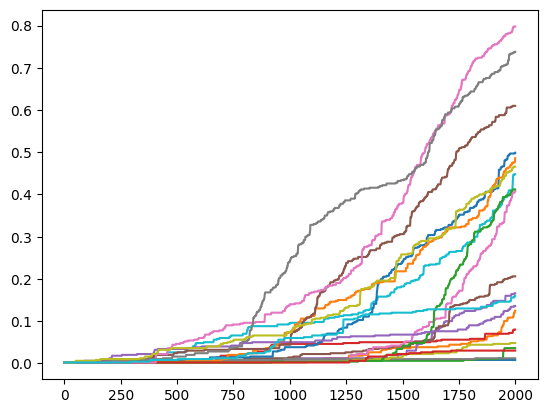

In [69]:
plot_results(xtx, 0 )

In [6]:
def run_simulation(modality : str, structure_no : int):
    results_dict_list = []
    for degree in geometric_graph_conf['mean_degrees']:
        results_dict = {
            "timesteps_saturation" : [],
            "fraction_infected_list" : [],
            "info_dict" : []
        }
        print(f"simulation run for degree {degree}")
        for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
            graphgen = GraphStructureGenerator(
                structure_name=geometric_graph_conf['structure_names'][structure_no], 
                num_nodes=int(geometric_graph_conf['nodes']), 
                target_mean_degree = degree
            )
            graph = graphgen.initial_adj_matrix
            graph_rand = graphgen.get_graph_structure().initial_adj_matrix

            x = ProceduralGraphGenerator(graph)
            infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
                modality=modality, verbose= False
            )

            results_dict["timesteps_saturation"].append(timesteps_saturation)
            results_dict["fraction_infected_list"].append(fraction_infected_list)
            results_dict["info_dict"].append(info_dict)
        
        results_dict_list.append(results_dict)
    return results_dict_list
    
def clean_results(results_dict_list : list):
    import itertools
    for result in tqdm.tqdm(results_dict_list): 
        for key in result.keys():
            if key == "fraction_infected_list":
                # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
                padded_list = np.array(
                    list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
                )
                result[key] = padded_list
                #result[key] = np.mean(padded_list, axis=0)
            if key == "info_dict":
                info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
                for key in info_dict_temp.keys():
                    if key == "modality":
                        info_dict_temp[key] = result['info_dict'][0]['modality']
                    else:
                        info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
                result['info_dict'] = info_dict_temp
            
        result['average_timesteps'] = np.average(result['timesteps_saturation'])
    return results_dict_list   

def plot_results(results_dict_list : dict, structure_no : int ):
    for i, result in enumerate(results_dict_list): 
        print(result['info_dict'])
        for iter in result['fraction_infected_list']:
            timesteps_list = [x for x in range(len(iter))]
            #try:
            #    p, cov = curve_fit(logistic, timesteps_list, iter)
            #    logistic_curve_data = logistic(timesteps_list, *p)
            #except:
            #    pass
            plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
        #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
        plt.title(f"saturation curve for {geometric_graph_conf['structure_names'][structure_no]} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
        plt.legend()
        plt.show()

REVERSABLE GEOMETRIC GRAPH SIMULATION

In [7]:
results_dict_list_geometric_reversable = run_simulation("reversable", 0)

simulation run for degree 2


20it [01:11,  3.58s/it]


simulation run for degree 5


20it [02:11,  6.57s/it]


simulation run for degree 10


20it [02:28,  7.44s/it]


simulation run for degree 15


20it [02:58,  8.92s/it]


simulation run for degree 20


20it [03:23, 10.20s/it]


In [8]:
cleaned_results_dict_list_geometric_reversable = clean_results(results_dict_list_geometric_reversable)

100%|██████████| 5/5 [00:00<00:00, 197.50it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'average_degree': 3.057021669395676, 'num_nodes': 25.7, 'modality': 'reversable', 'clustering_coefficient': 0.4715676569200566, 'degree_assortivity': 0.2331722156471236, 'mean_shortest_pathlength': 4.840293571091729}


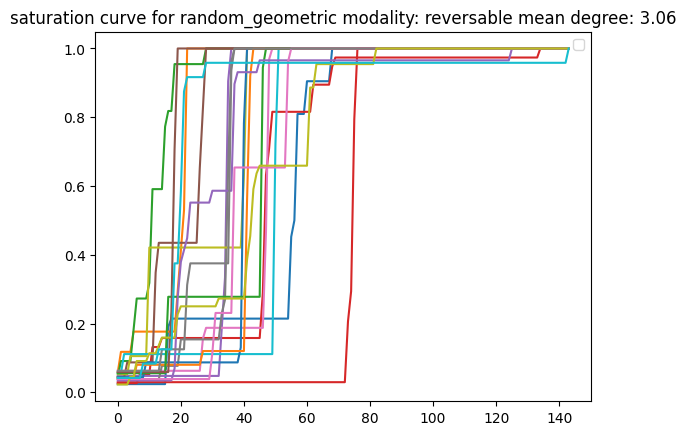

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'average_degree': 5.203585058268432, 'num_nodes': 402.85, 'modality': 'reversable', 'clustering_coefficient': 0.5786179190721124, 'degree_assortivity': 0.5448792144994925, 'mean_shortest_pathlength': 17.332501674527926}


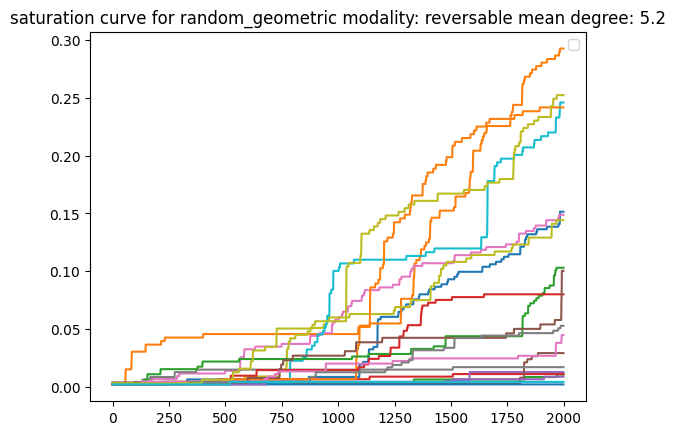

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'average_degree': 10.020850724028701, 'num_nodes': 499.4, 'modality': 'reversable', 'clustering_coefficient': 0.6093480787922276, 'degree_assortivity': 0.582211690123377, 'mean_shortest_pathlength': 8.751903620074675}


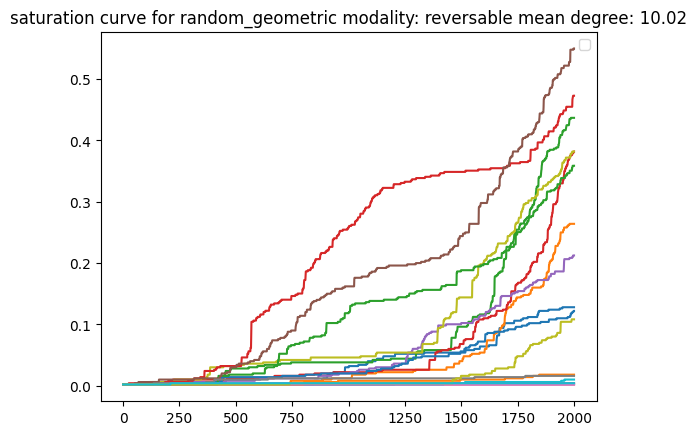

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'average_degree': 14.989297795591181, 'num_nodes': 499.95, 'modality': 'reversable', 'clustering_coefficient': 0.6193808441453983, 'degree_assortivity': 0.5462440209816993, 'mean_shortest_pathlength': 6.667024207451047}


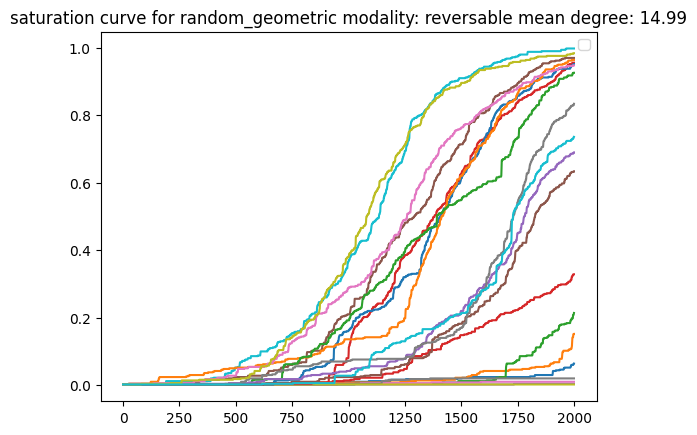

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'average_degree': 20.0136, 'num_nodes': 500.0, 'modality': 'reversable', 'clustering_coefficient': 0.6248528038207481, 'degree_assortivity': 0.5791973024721324, 'mean_shortest_pathlength': 5.578297795591181}


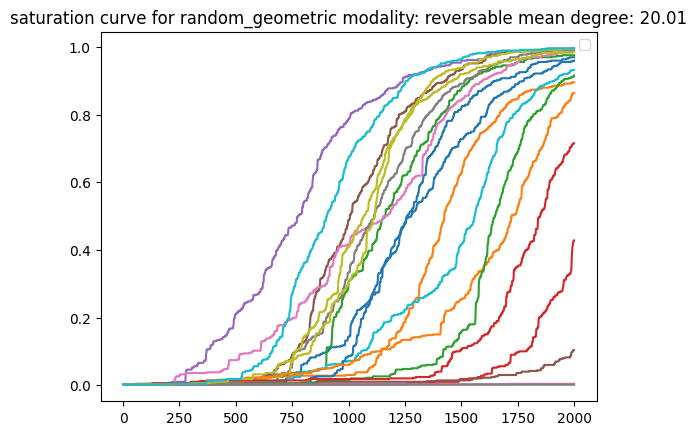

In [9]:
plot_results(cleaned_results_dict_list_geometric_reversable, 0)

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

In [10]:
results_dict_list_geometric_irreversable = run_simulation("irreversable", 0)

simulation run for degree 2


20it [01:11,  3.56s/it]


simulation run for degree 5


13it [05:58, 27.54s/it]


KeyboardInterrupt: 

In [ ]:
cleaned_results_dict_list_geometric_irreversable = clean_results(results_dict_list_geometric_irreversable)

In [ ]:
plot_results(cleaned_results_dict_list_geometric_irreversable, 0 )

Results for reversable albert simulation 

In [ ]:
results_dict_list_albert_reversable = run_simulation("reversable", 1)

In [ ]:
cleaned_results_dict_list_albert_reversable = clean_results(results_dict_list_albert_reversable)

In [ ]:
plot_results(cleaned_results_dict_list_albert_reversable, 0 )

Results for irreversable albert simulation 

In [ ]:
results_dict_list_albert_irreversable = run_simulation("irreversable", 1)

In [ ]:
cleaned_results_dict_list_albert_irreversable = clean_results(results_dict_list_albert_irreversable)

In [ ]:
plot_results(cleaned_results_dict_list_albert_irreversable, 0 )

In [ ]:
rwgr

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
result['info_dict']

In [ ]:
for i, result in enumerate(results_dict_list): 
    print(result['info_dict'])
    for iter in result['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        try:
            p, cov = curve_fit(logistic, timesteps_list, iter)
            logistic_curve_data = logistic(timesteps_list, *p)
        except:
            pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for {geometric_graph_conf['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
results_dict_list = []
modality = "irreversable"
for graph_rad in geometric_graph_conf['graph_edge_radii']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph radius {graph_rad}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=geometric_graph_conf['structure_name'], 
            num_nodes=int(geometric_graph_conf['nodes']), 
            graph_edge_radius = float(graph_rad)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for i, result in enumerate(results_dict_list): 
    print(result['info_dict'])
    for iter in result['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        try:
            p, cov = curve_fit(logistic, timesteps_list, iter)
            logistic_curve_data = logistic(timesteps_list, *p)
        except:
            pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for {geometric_graph_conf['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
albert_graph_config = conf['barabasi_albert']
albert_graph_config

In [ ]:
results_dict_list = []
modality = "reversable"
for node_degree in albert_graph_config['node_degree']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph degree {node_degree}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=albert_graph_config['structure_name'], 
            num_nodes=int(albert_graph_config['nodes']), 
            node_degree = int(node_degree)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for i, result in enumerate(results_dict_list): 
    for iter in result['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        try:
            p, cov = curve_fit(logistic, timesteps_list, iter)
            logistic_curve_data = logistic(timesteps_list, *p)
        except:
            pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for {albert_graph_config['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
results_dict_list = []
modality = "irreversable"
for node_degree in albert_graph_config['node_degree']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph degree {node_degree}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=albert_graph_config['structure_name'], 
            num_nodes=int(albert_graph_config['nodes']), 
            node_degree = int(node_degree)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for result in results_dict_list: 
    timesteps_list = [x for x in range(len(result['fraction_infected_list']))]

    p, cov = curve_fit(logistic, timesteps_list, result['fraction_infected_list'])
    logistic_curve_data = logistic(timesteps_list, *p)
    print("run statistics")
    print(result['info_dict'])
    plt.plot(timesteps_list, result['fraction_infected_list'], label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for modality {result['info_dict']['modality']} mean degree {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
try: 
            #Fit a logistic curve to the simulated infection data for one simulation run, generate data with this logistic, use to find residuals in fit
            p, cov = curve_fit(logistic, timesteps, fraction_infected_list)
            logistic_curve_data = logistic(timesteps, *p)
            residuals_dict[graph_rad].extend(fraction_infected_list - logistic_curve_data)
            mean_degree_simulation_runs.append(average_degree)
        except RuntimeError as e:
            print(e)
            pass 
    average_degrees.append(np.mean(mean_degree_simulation_runs))

#Update keys of dictionary so that keys are the (averaged) mean degree of the simulations networks
residuals_dict = {k : v for k,v in list(zip(average_degrees, residuals_dict.values()))}
least_noisy_data = residuals_dict
for key in residuals_dict.keys(): 
    sns.kdeplot(residuals_dict[key], label=f"mean degree : {round(key, 2)}")
plt.legend()
plt.show()